# Case7-challenge03

In this note, we estimate the field parameters and sky coordinates of objects from the observed positions on the focal plane and pointing information. The data is the updated version of case7. The pointing positions are fixed as constants in this note. The SIP-convention distortion is considered in this note.

## Preparation

At first, we add the analysis directry to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

Next, we load the data.

In [2]:
import astropy.io.ascii as asc
import astropy.units as u

objects = asc.read('case7_challenge_03.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('case7_challenge_03_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

We convert the units of x and y from um to pix with assuming the pixel size to be 15 um.

In [3]:
pix_size = 15.*u.um
objects['x'] = (objects['x']/pix_size).si
objects['y'] = (objects['y']/pix_size).si
# objects: x (px), y (px), catalog_id, ra (deg), dec (deg), and field.
# pointings: field, ra (deg), dec (deg), and pa (deg).

Then, we change the ids for easy handling.

In [4]:
from astropy.table import unique
import numpy as np

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

Here, we make some arrays for further analysis. One new array is true_radec which stores true ra/dec values. Duplicated information (rows for the same object) is removed, and the rows are sorted with object ids. Another new array is observed_xy. It contains field ids, observed x/y positions on the focal plane, catalog ids, and estimated ra/dec values instead of true ra/dec values. The estimated ra/dec values are initialized to be zero at this moment.

In [5]:
true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
observed_xy.rename_column('ra', 'ra_est')
observed_xy.rename_column('dec', 'dec_est')
# observed_xy will have field, x (px), y (px), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

In addition, we make another array which stores field parameters. The plate scale is assumed to be the same value for all plates. At this time, an approximated value is stored in a variable (plate_scale).

In [6]:
field_params = pointings.copy() # field, ra (deg), dec (deg), and pa (deg).
plate_scale = 8.e-6*u.deg*(pix_size/u.um).si # in deg/pix

Let's check the object distribution on sky.

Text(0, 0.5, 'dec (deg)')

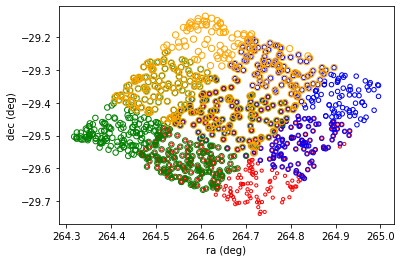

In [8]:
import matplotlib.pylab as plt
import numpy as np

color = ['red', 'blue', 'green', 'orange']

for i in range(0, np.max(field_params['field'])+1):
    pos = np.where(objects['field']==i)
    plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='o', facecolor='None', edgecolor=color[i], s=10*i+10)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

We can see that the data consists of four regions and that the overlapped region has a size of about a 1/4 FoV.

We select the objects in the overlapped region for further analysis.

In [9]:
true_radec_overlap = true_radec.copy()
observed_xy_overlap = observed_xy.copy()
for cid in true_radec['catalog_id']:
    if np.count_nonzero(observed_xy['catalog_id']==cid)!=4:
        pos = np.where(true_radec_overlap['catalog_id']==cid)[0]
        true_radec_overlap.remove_rows(pos)
        pos = np.where(observed_xy_overlap['catalog_id']==cid)[0]
        observed_xy_overlap.remove_rows(pos)

Let's check the distribution of the selected objects.

Text(0, 0.5, 'dec (deg)')

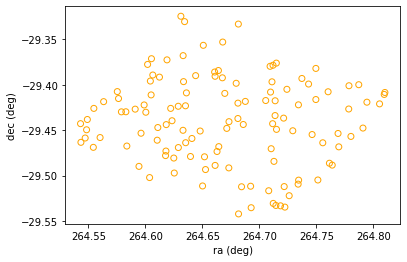

In [10]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='o', facecolor='None', edgecolor='orange')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

These objects will be used for the following analysis.

We again modify the catalog id for easy handling.

In [11]:
ids = unique(true_radec_overlap, keys='catalog_id')['catalog_id']
true_radec_overlap.add_column(-1, name='id')
observed_xy_overlap.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(true_radec_overlap['catalog_id']==ids[i])
    true_radec_overlap['id'][pos] = i
    pos = np.where(observed_xy_overlap['catalog_id']==ids[i])
    observed_xy_overlap['id'][pos] = i

true_radec_overlap.remove_column('catalog_id')
true_radec_overlap.rename_column('id', 'catalog_id')
observed_xy_overlap.remove_column('catalog_id')
observed_xy_overlap.rename_column('id', 'catalog_id')

## First guess of the positions

At first, we define a wcs constructor.

In [12]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[np.cos(pa_ptg*u.deg), -np.sin(pa_ptg*u.deg)],
              [np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

Then, we estimate the sky coordinates from the observed focal-plane positions and (approximated) field parameters.

In [13]:
for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    observed_xy_overlap['ra_est'][pos]  = ret[:, 0]
    observed_xy_overlap['dec_est'][pos] = ret[:, 1]

Let's check the true positions and estimated positions.

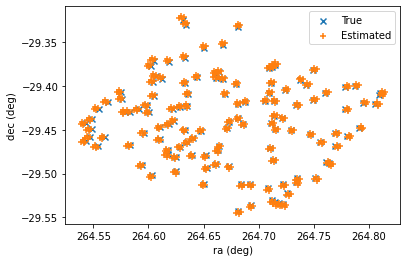

In [14]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='Estimated')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

Here, there are four estimated positions for each object. We take their mean values as the first-guess positions and store them in radec_est array.

In [15]:
from astropy.table import Table

radec_est = Table(names=['catalog_id', 'ra_est', 'dec_est'],\
           units=[None, u.deg, u.deg],\
           dtype=['int64', 'float64', 'float64'])

cat_ids = unique(observed_xy_overlap, 'catalog_id')['catalog_id']

for i in cat_ids:
    pos = np.where(observed_xy_overlap['catalog_id'] == i)
    ra = np.mean(observed_xy_overlap[pos]['ra_est'])*u.deg
    dec = np.mean(observed_xy_overlap[pos]['dec_est'])*u.deg
    radec_est.add_row([i, ra, dec])

Let's check the estimated positions.

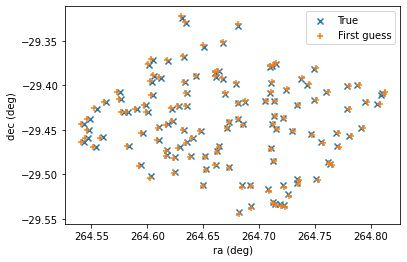

In [16]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='First guess')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

## Parameter adjustment

At first, we define a function which calculates x/y positions from the ra/dec values estimated above and the field/catalog ids.

In [17]:
def xy_calculator(observed_xy, field_params, plate_scale, ap, bp, radec_info):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, ap=ap, bp=bp)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        radec0 = np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T
        ret = w.sip_foc2pix(w.wcs_world2pix(radec0, 0)-w.wcs.crpix, 0)
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

Then, we define a model function to be used in the least-square calculation.

In [18]:
def model(params, ra_ptgs, dec_ptgs, n_fields, n_objects, dim_sip, observed_xy):
    # params = (pa_ptg..., scale, a..., b..., ra_obj..., dec_obj)
    pa_ptgs, scale, ap, bp, ra_objs, dec_objs =\
        np.split(params, [n_fields, n_fields+1,\
                          n_fields+1+(dim_sip+1)**2, n_fields+1+2*(dim_sip+1)**2,\
                          n_fields+1+2*(dim_sip+1)**2+n_objects])
    
    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         units=[u.deg, u.deg, u.deg, None],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
    
    ap_matrix = np.reshape(ap, (dim_sip+1, dim_sip+1))
    bp_matrix = np.reshape(bp, (dim_sip+1, dim_sip+1))
    
    mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1)))    
    for mn in mns:
        for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
            n = mn - m
            ap_matrix[m, n] = 0
            bp_matrix[m, n] = 0

    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    ap_matrix = ap_matrix * (1.e-3**mn)
    bp_matrix = bp_matrix * (1.e-3**mn)
    
    radec_info = Table(data=[ra_objs, dec_objs, -np.ones(shape=(np.size(ra_objs)))],\
                       names=['ra_est', 'dec_est', 'catalog_id'],\
                       units=[u.deg, u.deg, None],\
                       dtype=['float64', 'float64', 'int64'])
    
    field_params['field'] = np.arange(0, np.size(field_params))
    radec_info['catalog_id'] = np.arange(0, np.size(radec_info))
    
    ret = xy_calculator(observed_xy, field_params, scale[0], ap_matrix, bp_matrix, radec_info)

    return np.concatenate((ret['x_est'], ret['y_est']))

Next, we execute the least-square calculation to derive the field parameters and sky positions of the objects in the overlapped region.

In [19]:
from common.leastsquare import LeastSquare

dim_sip = 4
ap = np.zeros(shape=(dim_sip+1, dim_sip+1))
bp = np.zeros(shape=(dim_sip+1, dim_sip+1))

ls = LeastSquare(lambda a: model(a, field_params['ra'], field_params['dec'],\
                                 np.size(field_params), np.size(radec_est), dim_sip, observed_xy_overlap),\
                 np.size(observed_xy_overlap)*2)

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['pa'], [plate_scale.value], ap.flatten(), bp.flatten(),\
                                  radec_est['ra_est'], radec_est['dec_est']))) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
measured = np.concatenate((observed_xy_overlap['x'], observed_xy_overlap['y']))
#pos = np.where(measured>180.)
#measured[pos] -= 360.
#pos = np.where(measured<-180.)
#measured[pos] += 360.

result, _ = ls.solve(measured, a_init, max_iteration=100, epsilon=1.e-8)

## pa should be a positive value between 0 and 360.
#if result[3] < 0:
#    result[3] = -result[3]
#    result[2] = result[2] + 180.0
#
#if result[2] > 360.0 or result[2] < 0.0:
#    result[2] = result[2]%360.0

2021-07-24 15:11:00,483  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-24 15:11:00,520  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.240602)
2021-07-24 15:11:04,789  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-24 15:11:04,827  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.062794)
2021-07-24 15:11:09,191  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-24 15:11:09,222  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.021340)
2021-07-24 15:11:13,534  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-24 15:11:13,572  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm 

### Checking results

#### Preparation

In [20]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
ra_ptgs = field_params['ra']
dec_ptgs= field_params['dec']
pa_ptgs, scale, ap, bp, ra_objs, dec_objs =\
    np.split(result, [n_fields, n_fields+1,\
                      n_fields+1+(dim_sip+1)**2, n_fields+1+2*(dim_sip+1)**2,\
                      n_fields+1+2*(dim_sip+1)**2+n_objects])

#### Scale (deg/pix)

In [21]:
scale

array([0.00011773])

#### Object positions

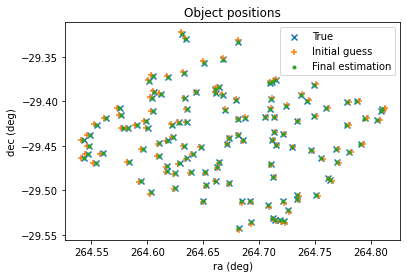

In [22]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(ra_objs, dec_objs, marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

#### AP/BP matrices (must be scaled as described in the model function)

In [23]:
np.reshape(ap, (dim_sip+1, dim_sip+1))

array([[-1.06538678e-12,  1.05119441e-12, -5.88573616e-02,
        -8.39695246e-03, -8.49286585e-02],
       [ 6.60139224e-13,  1.78103714e-02, -7.04376282e-03,
         4.19264537e-03, -1.86205015e-12],
       [-1.86648117e-03, -4.26696728e-03, -3.24645950e-02,
         6.16233690e-13, -2.79436635e-13],
       [ 5.71140916e-03, -3.41788423e-02,  1.09476789e-12,
         7.74437145e-13, -1.64022430e-12],
       [ 4.42612502e-04,  1.72808608e-12, -3.65616439e-13,
         7.02794661e-12, -4.64482333e-13]])

In [24]:
np.reshape(bp, (dim_sip+1, dim_sip+1))

array([[ 1.10190735e-12, -3.61790782e-14, -8.94027778e-03,
        -4.23099845e-03, -6.15954686e-03],
       [-6.83204994e-14, -3.84843146e-03, -4.14178591e-03,
        -7.33849578e-03, -1.67133289e-14],
       [ 1.17250835e-01,  1.68665158e-02,  1.58884535e-02,
         3.21288295e-14,  1.58671979e-14],
       [-4.63056916e-03, -6.63078997e-03,  1.46271950e-14,
        -8.50469190e-15, -5.16428659e-14],
       [ 1.66261199e-01, -4.40880856e-14, -1.96920749e-14,
         1.58596586e-15, -1.22825760e-14]])

#### Position difference

In [25]:
from astropy.coordinates import SkyCoord

distlist = []
for i in range(0, np.size(ra_objs)):
    c1 = SkyCoord(ra_objs[i]*u.deg, dec_objs[i]*u.deg)
    c2 = SkyCoord(true_radec_overlap['ra'][i]*u.deg, true_radec_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

Text(0, 0.5, 'Number')

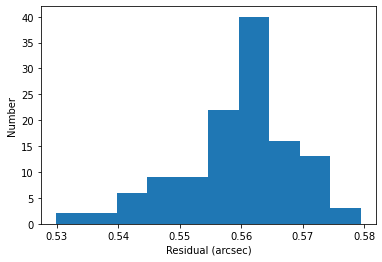

In [26]:
#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

#### Residual in focal-plane positions

(-0.2, 0.2)

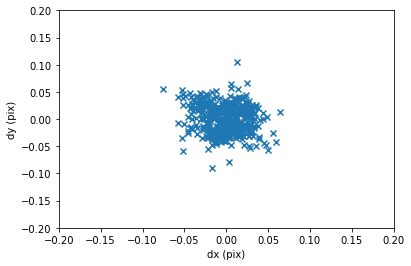

In [27]:
ret = model(result, field_params['ra'], field_params['dec'], n_fields, n_objects, dim_sip, observed_xy_overlap)
dx = ret[0:int(ret.size*0.5)] - observed_xy_overlap['x']
dy = ret[int(ret.size*0.5):int(ret.size)] - observed_xy_overlap['y']
#plt.scatter(observed_xy_overlap['x'], observed_xy_overlap['y'], marker='+')
#plt.scatter(ret[0:900], ret[900:1800], marker='x')
plt.scatter(dx, dy, marker='x')
plt.xlabel('dx (pix)')
plt.ylabel('dy (pix)')
plt.xlim([-0.2, 0.2])
plt.ylim([-0.2, 0.2])

In [ ]:
ret.size